In [512]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
import mysql.connector
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import time
from user_agent import generate_user_agent, generate_navigator
from selenium.common.exceptions import UnexpectedAlertPresentException
import requests
import datetime

import mysql
import matplotlib.pyplot as plt
import cv2 
import os
import glob
import joblib

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet50_Weights
import  torch.nn.functional as F


import MeCab
from konlpy.tag import Okt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from deep_translator import GoogleTranslator

import sys
sys.path.append('/Users/anhyojun/WorkSpace/KDT2/MyModule')
from KDTModule import *

In [513]:
def movie_crawling(webdriver_path, service, driver, id):
    webdriver_path = webdriver_path
    service = service
    driver = driver
    try:
        url = f'http://cine21.com/movie/info/?movie_id={id}'
        driver.get(url)
        time.sleep(2)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        ko_name = soup.find('p', class_='tit').text
        story = soup.find('div', class_='story').text.strip().replace('\t', '').replace('\n', ' ').replace('  ', ' ')
        if story == '':
            story = None

        for i in range(1, 6):
            if soup.find('span', class_=f'grade00{i}') != None:
                grade = soup.find('span', class_=f'grade00{i}').text
                break
            elif i == 5: grade = None

        return [ko_name, grade, story]
    
    except UnexpectedAlertPresentException as e1:
        return e1.alert_text
    
    except IndexError as e2:
        return '영화 정보 불충분'
    
    except AttributeError as e3:
        return '일시적으로 서비스 장애가 발생하였습니다.'

In [514]:
create_table_query = """
CREATE TABLE IF NOT EXISTS movies (
    ko_name VARCHAR(255),
    grade VARCHAR(255),
    story VARCHAR(255),"""

In [4]:
# MySQL 연결 설정
conn = mysql.connector.connect(
    host = '155.230.153.151',
    user = 'spiderman',
    password = '1234',
    database = 'avengers'
)

cursor = conn.cursor()

cursor.execute(create_table_query)
conn.commit()
print("테이블이 성공적으로 생성되었습니다")

conn.close()

테이블이 성공적으로 생성되었습니다


In [5]:
# My SQL 데이터베이스 연결
conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'signcity114',
    database = 'MyDB'
)

# 연결 확인
if conn.is_connected():
    print("MySQL에 성공적으로 연결되었습니다")
else:
    print("MySQL 연결 실패")

cursor = conn.cursor()

webdriver_path = '/Users/anhyojun/WebDriver/chromedriver'
service = Service(webdriver_path)
driver = webdriver.Chrome(service=service)

insert_query = """
INSERT INTO movie
VALUES (%s, %s, %s)"""

for i in range(1, 70000):
    data = movie_crawling(webdriver_path, service, driver, i)
    if data == '존재하지 않는 영화입니다.':
        print(data)
        continue
    elif data == '성인용 컨텐츠입니다. 로그인 해 주세요.':
        print(data)
        continue
    elif data == '영화 정보 불충분':
        print(data)
        continue
    elif data == '일시적으로 서비스 장애가 발생하였습니다.':
        print(data)
        continue
    cursor.execute(insert_query, data)
    conn.commit()
    print(data)

In [416]:
# # MySQL 연결 설정
# conn = mysql.connector.connect(
#     host = '155.230.153.151',
#     user = 'spiderman',
#     password = '1234',
#     database = 'avengers'
# )

# # 커서 객체 생성
# cursor = conn.cursor()

# SQL 쿼리문
query = """
SELECT ko_name, grade, genre, story FROM movie
WHERE (grade IS NOT NULL)
and (story IS NOT NULL)
and (ko_name IS NOT NULL)
and (genre IS NOT NULL)
and (story != '줄거리가 없습니다.')
and (genre not like '%단편 영화%')
and (char_length(story) > 50);
"""

# SQL 쿼리 실행
df = pd.read_sql(query, conn)

# # 데이터프레임 csv로 로컬에 저장
# df.to_csv('movieDF.csv', index=False)

In [515]:
torch.manual_seed(1)

In [516]:
movie = pd.read_csv('movieDF.csv')

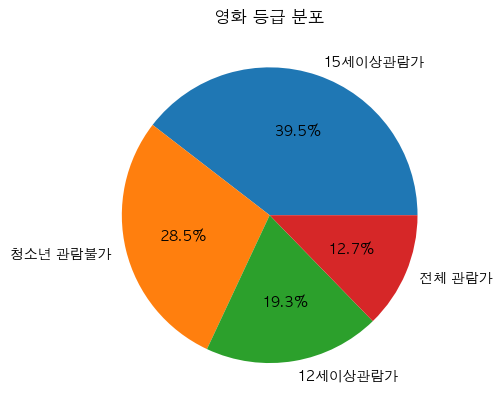

In [517]:
grade_values = movie['grade'].value_counts()
plt.pie(grade_values.values, labels=grade_values.index, autopct='%1.1f%%')
plt.title('영화 등급 분포')
plt.rc('font', family='AppleGothic')

In [420]:
movie_all = list(movie[movie['grade'] == '전체 관람가']['story'])
movie_12 = list(movie[movie['grade'] == '12세이상관람가']['story'])

In [421]:
# # 데이터 증강
# movie_all_translate = []

# for index, text in enumerate(movie_all):
#     english = GoogleTranslator(source='ko', target='en').translate(text)
#     if index % 30 == 0:
#         print(english)
#     korean = GoogleTranslator(source='en', target='ko').translate(english)
#     if index % 30 == 0:
#         print(korean)
#     movie_all_translate.append(korean)

In [422]:
# # 데이터 증강
# movie_12_translate = []

# for index, text in enumerate(movie_12):
#     english = GoogleTranslator(source='ko', target='en').translate(text)
#     if index % 30 == 0:
#         print(english)
#     korean = GoogleTranslator(source='en', target='ko').translate(english)
#     if index % 30 == 0:
#         print(korean)
#     movie_12_translate.append(korean)

In [518]:
movie2 = movie.drop('grade', axis=1)

In [519]:
total = []
for i in movie2.values:
    total.append(' '.join(i))
total

['히트 액션, 범죄, 드라마 LA 경찰국 강력계의 빈센트 한나(알 파치노) 반장은 두 번의 이혼 경력과 순탄치 않은 세 번째 결혼생활로 불안하고 우울한 일상을 이어간다. 어느 날 특급 우편 차량을 급습하는 사건이 일어나고 호송 요원 세 명이 무참히 살해되자 한나는 특유의 예리한 감으로 닐 맥컬리(로버트 드 니로)의 존재를 찾아낸다. 자신의 팀원들을 가족처럼 보살피는 빈틈없는 프로 범죄자 닐은 자신을 쫓는 한나를 비웃듯 따돌리고 닐의 용의주도하고 프로페셔널한 면모에 한나는 닐에 대한 관심과 승부욕이 생기기 시작하는데… 액션의 전설이 다시 부활한다!',
 '랜섬 액션, 범죄, 드라마 미국 4대 항공사인 엔디버 항공사의 사장이자 재력가인 톰 멀론은 성공의 상징이며 언제나 매스컴의 주목을 받고 있는 유명인사다. 뉴욕시의 과학발명품 경연대회가 있던 날 톰과 케이트의 아들인 숀이 납치된다. 범인들은 숀의 몸값으로 2백만 달러를 요구한다. FBI에서 사건을 맡지만 톰은 아들을 구하겠다는 일념으로 돈을 들고 약속 장소로 나간다. 1차 작전이 실패하고 극도로 불안한 톰은 방송에 출연해 유괴범을 잡는 사람에게 4백만 달러의 현상금을 지불하겠다는 선전포고를 한다.',
 '귀여운 여인 멜로·로맨스, 코미디 에드워드는 망해가는 회사를 사들여 나누어서 비싸게 파는 일을 하는 부유하고도 냉정한 사업가다. 사업차 로스엔젤레스로 간 그는 그 곳에서 비비안이라는 창녀를 만나 하룻밤을 지낸다. 그는 영화를 보면서 웃거나 목욕을 하며 노래를 부르는 그녀의 모습을 보고 하루가 아니라 한 주 동안 자신과 같이 지낼 것을 제안한다. 그리고 비비안은 에드워드와 중요한 자리에 참석하기 위해 완전히 딴 사람으로 변신한다. 계약 기간 동안 같이 지내게 된 리차드와 비비안은 서로에게 호감을 느낀다. 에드워드는 비비안과 함께 잠시 일에서 벗어나 한가로운 시간을 보내며 회사를 나누어 팔기만 하는 자신의 일에 대해 다시 한번 생각하게 된다.  계약했던 기간이 다 지나고 에드워드는 그녀를 계속 만나고 싶어하지만 비

In [426]:
story = movie['story']
grade = movie['grade']

In [427]:
with open('stopword.txt', 'r', encoding='utf-8') as f:
    stopwords = [i.strip() for i in f.readlines()]

total_clean_text = []
for text in story:
    token = Okt().morphs(text)
    clean_token = remove_punctuation(token)
    clean_token = remove_stopwords(clean_token, stopwords)
    total_clean_text.append(' '.join(clean_token))

KeyboardInterrupt: 

In [457]:
# df = pd.DataFrame({
#     'original_text' : story,
#     # 'clean_text' : total_clean_text,
#     'label' : grade
# })
df = pd.DataFrame({
    'story' : total,
    'grade' : grade
})

grade_dict = {'전체 관람가' : 0, '12세이상관람가' : 0, '15세이상관람가' : 1, '청소년 관람불가' : 1}
final_df = df.apply(lambda x : x.replace(grade_dict))
final_df

,story,grade
0,"히트 액션, 범죄, 드라마 LA 경찰국 강력계의 빈센트 한나(알 파치노) 반장은 두...",1
1,"랜섬 액션, 범죄, 드라마 미국 4대 항공사인 엔디버 항공사의 사장이자 재력가인 톰...",1
2,"귀여운 여인 멜로·로맨스, 코미디 에드워드는 망해가는 회사를 사들여 나누어서 비싸게...",1
3,"라스베가스를 떠나며 드라마, 멜로·로맨스 사랑이 짧으면 슬픔은 길어진다! 벤은 할리...",1
4,"보디가드 뮤직, 멜로·로맨스 “절대 그녀에게서 눈을 떼지 말 것” “절대 경호를 풀...",1
...,...,...
21597,"4월이 되면 그녀는 멜로·로맨스, 드라마 “아프고 슬프고 괴롭지만그래도 사람들은 사...",0
21598,춘천대첩 72시간 다큐멘터리 반드시 기억해야 할 승리가 온다! 역사에는 가정이 없다...,0
21599,위대한 부재 드라마 인질 없는 인질극을 벌인 아버지VS 아버지란 이름의 수수께끼를 ...,1
21600,"허 바디 드라마 “숨겨진 욕망, 또 하나의 격렬한 스포츠” 올림픽 메달을 노리던 프...",1


In [429]:
final_df1 = final_df[final_df['label'] == 1].iloc[:7000,:]
final_df0 = final_df[final_df['label'] == 0]

final_df = pd.concat([final_df0, final_df1])
final_df['label'].value_counts()

label
1    7000
0    6906
Name: count, dtype: int64

In [380]:
# final_df0 = final_df[final_df['label'] == 0]
# final_df1 = final_df[final_df['label'] == 1]
# final_df2 = final_df[final_df['label'] == 2]
# final_df3 = final_df[final_df['label'] == 3]

# final_df = pd.concat([final_df0, final_df1, final_df2.iloc[:5000,:], final_df3])
# final_df

In [459]:
# 훈련, 검증, 테스트 데이터 분리
# featureDF = final_df[['clean_text']]
# targetDF = final_df[['label']]

featureDF = final_df[['story']]
targetDF = final_df[['grade']]

train_inputDF, test_inputDF, train_targetDF, test_targetDF = train_test_split(featureDF, targetDF,
                                                                      stratify = targetDF,
                                                                      train_size = 0.9, random_state = 42)
train_inputDF, valid_inputDF, train_targetDF, valid_targetDF = train_test_split(train_inputDF, train_targetDF,
                                                                        stratify = train_targetDF,
                                                                        train_size = 0.9, random_state = 42)
print(f"[train] input : {train_inputDF.shape}, target : {train_targetDF.shape}")
print(f"[valid] input : {valid_inputDF.shape}, target : {valid_targetDF.shape}")
print(f"[test] input : {test_inputDF.shape}, target : {test_targetDF.shape}")

[train] input : (17496, 1), target : (17496, 1)
[valid] input : (1945, 1), target : (1945, 1)
[test] input : (2161, 1), target : (2161, 1)


In [476]:
max_features = 3000
vectorizer = TfidfVectorizer(max_features=max_features)
train_vector = vectorizer.fit_transform(train_inputDF['story']).toarray()
valid_vector = vectorizer.transform(valid_inputDF['story']).toarray()
test_vector = vectorizer.transform(test_inputDF['story']).toarray()

joblib.dump(vectorizer, f'tfidfvectorizer_{max_features}.pkl')

['tfidfvectorizer_3000.pkl']

In [477]:
train_vectorDF = pd.DataFrame(train_vector)
valid_vectorDF = pd.DataFrame(valid_vector)
test_vectorDF = pd.DataFrame(test_vector)
train_vectorDF

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.257031,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
17492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.167193,0.0
17493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
17494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


In [478]:
trainDS = CustomDataset(train_vectorDF, train_targetDF, feature_dim=2)
validDS = CustomDataset(valid_vectorDF, valid_targetDF, feature_dim=2)
testDS = CustomDataset(test_vectorDF, test_targetDF, feature_dim=2)

trainDL = DataLoader(trainDS, batch_size=128)
validDL = DataLoader(validDS, batch_size=128)
testDL = DataLoader(testDS, batch_size=128)

In [479]:
for X_batch, y_batch in trainDL:
    print(X_batch.shape)  # X_batch의 차원 출력
    break  # 첫 번째 배치만 확인하기 위해 루프를 중지

torch.Size([128, 1, 3000])


In [480]:
class TextModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_list, act_func, model, num_layers=1):
        super().__init__()
        # 입력층 (LSTM)
        if model == 'lstm':
            self.lstm_layer = nn.LSTM(input_size, hidden_list[0], num_layers, batch_first=True)
        elif model == 'rnn':
            self.rnn_layer = nn.RNN(input_size, hidden_list[0], num_layers, batch_first=True)
        elif model == 'gru':
            self.gru_layer = nn.GRU(input_size, hidden_list[0], num_layers, batch_first=True)
        # 은닉층
        self.hidden_layer_list = nn.ModuleList()
        for i in range(len(hidden_list)-1):
            self.hidden_layer_list.append(nn.Linear(hidden_list[i], hidden_list[i+1]))
        # 출력층
        self.output_layer = nn.Linear(hidden_list[-1], output_size)

        self.act_func = act_func
        self.dropout = nn.Dropout(0.5)
        self.model = model
        
    def forward(self, x):
        # 입력층
        if self.model == 'lstm':
            lstm_out, (hn, cn) = self.lstm_layer(x) # lstm_out : 모든 타입스텝 출력
            x = lstm_out[:, -1, :] # 마지막 타입스텝 출력
        elif self.model == 'rnn':
            rnn_out, hn = self.rnn_layer(x) # rnn_out : 모든 타입스텝 출력
            x = rnn_out[:, -1, :] # 마지막 타입스텝 출력
        elif self.model == 'gru':
            gru_out, hn = self.gru_layer(x) # gru_out : 모든 타입스텝 출력
            x = gru_out[:, -1, :] # 마지막 타입스텝 출력
        # 은닉층
        for layer in self.hidden_layer_list:
            x = layer(x)
            x = self.act_func(x)
            x = self.dropout(x)
        # 출력층
        return self.output_layer(x) # 로짓값

In [481]:
# import torch
# import torch.nn as nn

# class LSTMModel(nn.Module):
#     def __init__(self, input_size, output_size, hidden_list, act_func, model_type, num_layers=1, dropout_rate=0.5):
#         super().__init__()
        
#         # LSTM 레이어
#         self.lstm = nn.LSTM(input_size, hidden_list[0], num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        
#         # 은닉층
#         self.hidden_layer_list = nn.ModuleList()
#         for i in range(len(hidden_list)-1):
#             self.hidden_layer_list.append(nn.Linear(hidden_list[i], hidden_list[i+1]))
#             # 배치 정규화 추가
#             self.hidden_layer_list.append(nn.BatchNorm1d(hidden_list[i+1]))

#         # 출력층
#         self.output_layer = nn.Linear(hidden_list[-1], output_size)

#         self.act_func = act_func
#         self.model_type = model_type
#         self.dropout = nn.Dropout(dropout_rate)  # 드롭아웃 레이어 추가

#     def forward(self, x):
#         # LSTM 레이어를 통과
#         lstm_out, (hn, cn) = self.lstm(x)

#         # 마지막 타임스텝의 출력을 사용
#         x = lstm_out[:, -1, :]

#         # 은닉층
#         for layer in self.hidden_layer_list:
#             x = layer(x)
#             x = self.act_func(x)
#             x = self.dropout(x)  # 드롭아웃 적용

#         # 출력층
#         if self.model_type == 'regression':  # 회귀
#             return self.output_layer(x)
#         elif self.model_type == 'binary':  # 이진 분류
#             return torch.sigmoid(self.output_layer(x))
#         elif self.model_type == 'multiclass':  # 다중 분류
#             return self.output_layer(x)  # CrossEntropyLoss에서 log-softmax 처리
#         elif self.model_type == 'multilabel':  # 다중 레이블
#             return torch.sigmoid(self.output_layer(x))

In [500]:
from collections import Counter
Counter(train_targetDF['grade'])

Counter({1: 11903, 0: 5593})

In [501]:
from collections import Counter

# 각 클래스의 샘플 수 계산
class_counts = Counter(train_targetDF['grade'])  # train_labels는 각 샘플의 레이블 리스트
total_samples = sum(class_counts.values())

# 클래스별 가중치 계산 (샘플 수에 반비례)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# 파이토치 텐서로 변환
weights = torch.tensor(list(class_weights.values()), dtype=torch.float32)

In [502]:
weights

tensor([1.4699, 3.1282])

In [508]:
# def testing(test_DataLoader, model, model_type, num_classes=None,
#             MPS = None, device = None):
#     model.eval() # 검증 모드임을 명시적으로 선언 (검증용 통계치 사용 및 드롭아웃 비활성화)
#     total_loss_test = 0
#     total_score_test = 0

#     with torch.no_grad(): # 가중치 업데이트 없이 테스트 진행
#         for X_batch, y_batch in test_DataLoader:
#             if MPS == True:
#                 model.to(device)  # 모델을 MPS 장치로 이동
                
#                 X_batch = X_batch.to(device).float()
#                 y_batch = y_batch.to(device)

#             # (1) 순전파 (평가)
#             pred_test_y = model(X_batch)
#             # (2) 손실 함수 계산

#             if model_type == 'regression': # 회귀일 때
#                 loss_test = F.mse_loss(pred_test_y, y_batch)
#                 score_test = r2_score(pred_test_y, y_batch)

#             elif model_type == 'binary': # 이진 분류일 때
#                 pred_test_y = torch.sigmoid(pred_test_y) # 확률값 출력
#                 loss_test = F.binary_cross_entropy(pred_test_y, y_batch) # 확률값을 전달해야 함
#                 pred_test_y = pred_test_y.round() # 확률값을 0또는 1로 변환
#                 score_test = f1_score(pred_test_y, y_batch, task='binary') # 0또는 1로 변환된 값을 전달

#             elif model_type == 'multiclass': # 다중 분류일 때
#                 y_batch1D = y_batch.reshape(-1) # 다중 분류는 y가 반드시 1차원이어야 함.. (너무 불친절)
#                 loss_test = F.cross_entropy(pred_test_y, y_batch1D.long(), weight=weights.to(device)) 
#                 pred_test_labels = torch.argmax(pred_test_y, dim=1)
#                 # dim=1을 해야 한 행 내에서 가장 큰 원소의 인덱스를 가져옴
#                 score_test = f1_score(pred_test_labels, y_batch1D,
#                                       task='multiclass', num_classes=num_classes)
#                 # 다중 분류는 long타입으로 전달해야 하는듯

#             elif model_type == 'multilabel': # 다중 레이블일 때
#                 pred_test_y = torch.sigmoid(pred_test_y) # OvR 확률값 출력
#                 loss_test = F.binary_cross_entropy(pred_test_y, y_batch) # 확률값을 전달해야 함
#                 pred_test_y = (pred_test_y > 0.5).float() # 각 컬럼 마다 0 또는 1의 예측값 출력
#                 score_test = f1_score(pred_test_y, y_batch, num_labels=num_classes,
#                                        average='micro', task='multilabel') # 다중 레이블은 micro가 적합

#             total_loss_test += loss_test.item()
#             total_score_test += score_test.item()

#     loss_test_avg = total_loss_test / len(test_DataLoader)
#     score_test_avg = total_score_test / len(test_DataLoader)
#     return loss_test_avg, score_test_avg

# # -----------------------------------------------------------------
# # 모델 학습 함수
# # -----------------------------------------------------------------
# def training(train_DataLoader, test_DataLoader, model, model_type, optimizer,
#              epoch = 1000, endurance_cnt = 10, view_epoch=1, num_classes=None, SAVE_PATH=None,
#              MPS = None, device = None):
#     model.train() # 학습 모드임을 명시적으로 선언 (학습용 통계치 사용)
#     loss_train_history = []
#     loss_test_history = []
#     score_train_history = []
#     score_test_history = []

#     EARLY_STOP_LOSS_CNT = 0

#     for i in range(1, epoch+1): # 에포크 횟수만큼 반복
#         total_loss_train = 0 # 한 에포크당 합산할 손실값 (나중에 평균 계산)
#         total_score_train = 0 # 한 에포크당 합산할 손실값 (나중에 평균 계산)

#         for X_batch, y_batch in train_DataLoader:
#             if MPS:
#                 model.to(device)  # 모델을 MPS 장치로 이동
#                 optimizer = optimizer # 디바이스가 설정된 바로 뒤에 optimizer를 위치

#                 X_batch = X_batch.to(device).float()
#                 y_batch = y_batch.to(device)
            
#             # (1) 순전파 (학습)
#             pred_train_y = model(X_batch)
#             # (2) 손실 함수 계산
#             if model_type == 'regression': # 회귀일 때
#                 loss_train = F.mse_loss(pred_train_y, y_batch)
#                 score_train = r2_score(pred_train_y, y_batch)

#             elif model_type == 'binary': # 이진 분류일 때
#                 pred_train_y = torch.sigmoid(pred_train_y) # 확률값 출력
#                 loss_train = F.binary_cross_entropy(pred_train_y, y_batch) # 확률값을 전달해야 함
#                 pred_train_y = pred_train_y.round() # 확률값을 0또는 1로 변환
#                 score_train = f1_score(pred_train_y, y_batch, task='binary') # 0또는 1로 변환된 값을 전달

#             elif model_type == 'multiclass': # 다중 분류일 때
#                 y_batch1D = y_batch.reshape(-1) # 다중 분류는 y가 반드시 1차원이어야 함.. (너무 불친절)
#                 loss_train = F.cross_entropy(pred_train_y, y_batch1D.long(), weight=weights.to(device))
#                 pred_train_labels = torch.argmax(pred_train_y, dim=1)
#                 # dim=1을 해야 한 행 내에서 가장 큰 원소의 인덱스를 가져옴
#                 score_train = f1_score(pred_train_labels, y_batch1D,
#                                        task='multiclass', num_classes=num_classes)
#                 # 다중 분류는 long타입으로 전달해야 하는듯

#             elif model_type == 'multilabel': # 다중 레이블일 때
#                 pred_train_y = torch.sigmoid(pred_train_y) # OvR 확률값 출력
#                 loss_train = F.binary_cross_entropy(pred_train_y, y_batch) # 확률값을 전달해야 함
#                 pred_train_y = (pred_train_y > 0.5).float() # 각 컬럼 마다 0 또는 1의 예측값 출력
#                 score_train = f1_score(pred_train_y, y_batch, num_labels=num_classes,
#                                        average='micro', task='multilabel') # 다중 레이블은 micro가 적합

#             # (3) 최적화
#             optimizer.zero_grad() # 그레디언트 초기화
#             loss_train.backward() # 역전파 하면서 그레디언트 계산
#             optimizer.step() # 가중치, 절편 업데이트
#             # (4) 손실값 합산
#             total_loss_train += loss_train.item()
#             total_score_train += score_train.item()

#         loss_train_avg = total_loss_train / len(train_DataLoader)
#         score_train_avg = total_score_train / len(train_DataLoader)
        
#         # 한 에포크마다 테스트 실행
#         if model_type == 'regression':
#             loss_test_avg, score_test_avg = testing(test_DataLoader, model, model_type='regression',
#                                                     MPS =  MPS, device = device)
#         elif model_type == 'binary':
#             loss_test_avg, score_test_avg = testing(test_DataLoader, model, model_type='binary',
#                                                     MPS = MPS, device = device)
#         elif model_type == 'multiclass':
#             loss_test_avg, score_test_avg = testing(test_DataLoader, model, model_type='multiclass',
#                                                     num_classes=num_classes, MPS = MPS, device = device)
#         elif model_type == 'multilabel':
#             loss_test_avg, score_test_avg = testing(test_DataLoader, model, model_type='multilabel',
#                                                     MPS = MPS, num_classes=num_classes, device = device)

#         loss_train_history.append(loss_train_avg)
#         loss_test_history.append(loss_test_avg)
#         score_train_history.append(score_train_avg)
#         score_test_history.append(score_test_avg)

#         if len(loss_test_history) == 1: # 첫 에포크일때
#             best_loss = loss_test_avg
#             if SAVE_PATH != None:
#                 torch.save({
#                     'model_state_dict' : model.state_dict(),
#                      'optimizer_state_dict' : optimizer.state_dict(),
#                       }, f'{SAVE_PATH}/best_model_epoch_{i}.pth')
#             print(f"[EPOCH] : {i}에서 모델 저장 완료.")

#         else:
#             if best_loss > loss_test_avg: # 손실값이 개선 됐다면
#                 best_loss = loss_test_avg
#                 EARLY_STOP_LOSS_CNT = 0 # 개선되면 카운트 초기화
#                 if SAVE_PATH != None:
#                     torch.save({
#                         'model_state_dict' : model.state_dict(),
#                          'optimizer_state_dict' : optimizer.state_dict(),
#                           }, f'{SAVE_PATH}/best_model_epoch_{i}.pth')
#                 print(f"[EPOCH] : {i}에서 모델 저장 완료.")
#             else:                         # 손실값이 개선되지 않았다면
#                 EARLY_STOP_LOSS_CNT += 1

#         if EARLY_STOP_LOSS_CNT == endurance_cnt:
#             print(f'[Loss]값의 개선이 이루어지지 않아 [{i}] EPOCH에서 학습을 종료합니다.')
#             break

#         # (4) 학습 결과 출력
#         if i % view_epoch == 0:
#             print(f"[Loss : {i}/{epoch}] Train : {loss_train_avg:.4f}, Test : {loss_test_avg:.4f}")
#             print(f"[Score  : {i}/{epoch}] Train : {score_train_avg:.4f}, Test : {score_test_avg:.4f}")

#         # 여기서 GPU 캐시를 정리
#         if MPS:
#             torch.cuda.empty_cache()
    
#     return loss_train_history, loss_test_history, score_train_history, score_test_history

In [511]:
model = LSTMModel(input_size = 3000, output_size = 1, hidden_list = [100],
                  act_func=F.relu, model_type='binary', num_layers=2)
# num_layers : 재귀층(Recurrent Layer)의 개수 (기본적인 LSTM 모델에서는 1개)

adam_optim = optim.Adam(model.parameters(), lr = 0.001)

# 모델 훈련
EPOCH = 200
SAVE_PATH = '/Users/anhyojun/WorkSpace/KDT2/김소현 강사님/프로젝트/6번째 프로젝트/model_tf-idf'
result = training(trainDL, validDL, model, 'binary', adam_optim, EPOCH,
                  endurance_cnt=10, num_classes=1, SAVE_PATH=SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/200] Train : 0.6167, Test : 0.5789
[Score  : 1/200] Train : 0.8092, Test : 0.8105
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/200] Train : 0.5476, Test : 0.5477
[Score  : 2/200] Train : 0.8092, Test : 0.8105
[Loss : 3/200] Train : 0.5234, Test : 0.5499
[Score  : 3/200] Train : 0.8092, Test : 0.8105
[Loss : 4/200] Train : 0.5140, Test : 0.5515
[Score  : 4/200] Train : 0.8092, Test : 0.8105
[Loss : 5/200] Train : 0.5128, Test : 0.5515
[Score  : 5/200] Train : 0.8094, Test : 0.8105
[Loss : 6/200] Train : 0.5116, Test : 0.5545
[Score  : 6/200] Train : 0.8104, Test : 0.8129
[Loss : 7/200] Train : 0.5075, Test : 0.5502
[Score  : 7/200] Train : 0.8132, Test : 0.8195
[Loss : 8/200] Train : 0.5007, Test : 0.5520
[Score  : 8/200] Train : 0.8282, Test : 0.8453
[Loss : 9/200] Train : 0.4979, Test : 0.5521
[Score  : 9/200] Train : 0.8452, Test : 0.8500
[Loss : 10/200] Train : 0.4975, Test : 0.5529
[Score  : 10/200] Train : 0.8519, Test : 0.8437
[Loss : 11/200] Train : 0.4981

In [483]:
model = LSTMModel(input_size = 3000, output_size = 4, hidden_list = [100],
                  act_func=F.relu, model_type='multiclass', num_layers=2)
# num_layers : 재귀층(Recurrent Layer)의 개수 (기본적인 LSTM 모델에서는 1개)

adam_optim = optim.Adam(model.parameters(), lr = 0.001)

# 모델 훈련
EPOCH = 200
SAVE_PATH = '/Users/anhyojun/WorkSpace/KDT2/김소현 강사님/프로젝트/6번째 프로젝트/model_tf-idf'
result = training(trainDL, validDL, model, 'multiclass', adam_optim, EPOCH,
                  endurance_cnt=10, num_classes=4, SAVE_PATH=SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/200] Train : 0.7926, Test : 0.6060
[Score  : 1/200] Train : 0.6805, Test : 0.6822
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/200] Train : 0.5332, Test : 0.4764
[Score  : 2/200] Train : 0.7304, Test : 0.7850
[Loss : 3/200] Train : 0.4281, Test : 0.4854
[Score  : 3/200] Train : 0.8033, Test : 0.7747
[Loss : 4/200] Train : 0.3999, Test : 0.5040
[Score  : 4/200] Train : 0.8203, Test : 0.7683
[Loss : 5/200] Train : 0.3864, Test : 0.5207
[Score  : 5/200] Train : 0.8275, Test : 0.7569
[Loss : 6/200] Train : 0.3782, Test : 0.5345
[Score  : 6/200] Train : 0.8314, Test : 0.7471
[Loss : 7/200] Train : 0.3723, Test : 0.5460
[Score  : 7/200] Train : 0.8362, Test : 0.7428


KeyboardInterrupt: 

In [490]:
model = LSTMModel(input_size = 3000, output_size = 4, hidden_list = [50],
                  act_func=F.relu, model_type='multiclass', num_layers=2)
# num_layers : 재귀층(Recurrent Layer)의 개수 (기본적인 LSTM 모델에서는 1개)

adam_optim = optim.Adam(model.parameters(), lr = 0.001)

# 모델 훈련
EPOCH = 200
SAVE_PATH = '/Users/anhyojun/WorkSpace/KDT2/김소현 강사님/프로젝트/6번째 프로젝트/model_tf-idf'
result = training(trainDL, validDL, model, 'multiclass', adam_optim, EPOCH,
                  endurance_cnt=10, num_classes=4, SAVE_PATH=SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/200] Train : 0.7266, Test : 0.5555
[Score  : 1/200] Train : 0.6381, Test : 0.7174
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/200] Train : 0.4724, Test : 0.4777
[Score  : 2/200] Train : 0.7806, Test : 0.7791
[Loss : 3/200] Train : 0.4116, Test : 0.4953
[Score  : 3/200] Train : 0.8168, Test : 0.7723
[Loss : 4/200] Train : 0.3915, Test : 0.5109
[Score  : 4/200] Train : 0.8300, Test : 0.7639


KeyboardInterrupt: 